In [1]:
import pandas as pd
import numpy as np
from glob import  glob
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import calendar
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
import xarray as xr
from sklearn.cluster import KMeans
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
target_time = pd.date_range('19910101','20201231',freq='d')
df_times = pd.DataFrame({'index': target_time}, index=target_time)
df_times = df_times.drop(index=df_times[(df_times.index.day==29) & (df_times.index.month==2)].index)

paths = glob('data/raw/*')

def fix_name(d):
    return d.split(':')[-1].replace('\n','')[1:]

In [3]:
n_total_days = len(df_times)
print(f"observações esperadas {n_total_days}")

observações esperadas 10950


In [4]:
dfs = list()
for p in paths:
    
    with open(p) as file:
        data = file.readlines()
        names = ['name', 'cod', 'lat', 'lon', 'alt', 'status', 'init_at', 'end_at', 'freq']
        values = [fix_name(d) for d in data[:9]]
        cfg = dict(zip(names, values))

    df = pd.read_csv(p, sep=';', na_values=['-9999.0','null'], skiprows=9)

    for name, value in cfg.items():
        df[name] = value
    
    df.index = pd.to_datetime(df['Data Medicao'].values)
    df = df.loc['1991-01-01':'2020-12-31']
    df = df.drop(index=df[(df.index.day==29) & (df.index.month==2)].index)
    df = df_times.combine_first(df)

    
    tmed = df[['TEMPERATURA MAXIMA, DIARIA(°C)', 'TEMPERATURA MINIMA, DIARIA(°C)']].dropna().mean(axis=1)
    main_df = pd.DataFrame({'tmean': tmed}, index=pd.to_datetime(tmed.index))
    main_df = df_times.combine_first(main_df)
    
    df['tmean'] = main_df['tmean'].copy()
    
    total = len(main_df)
    total_nan = len(main_df) - len(main_df.dropna())
    percent_null = total_nan/total * 100
    
    df['percent_null'] = round(float(percent_null), 1)
    df = df.sort_values('index')

    if percent_null < 15:       

        assert len(df) == n_total_days
        dfs.append(df)  

In [5]:
sel_columns = [
    'Data Medicao', 
    'PRECIPITACAO TOTAL, DIARIO(mm)',
    'TEMPERATURA MAXIMA, DIARIA(°C)',
    #'TEMPERATURA MEDIA COMPENSADA, DIARIA(°C)',
    'tmean',
    'TEMPERATURA MINIMA, DIARIA(°C)',
    'UMIDADE RELATIVA DO AR, MEDIA DIARIA(%)', 
    'cod', 
    'lat', 
    'lon', 
    'alt',
    'name',
    'percent_null'
]
rename_cols = {
    'Data Medicao':'datas', 
    'PRECIPITACAO TOTAL, DIARIO(mm)':'prec',
    'TEMPERATURA MAXIMA, DIARIA(°C)':'tmax',
    #'TEMPERATURA MEDIA COMPENSADA, DIARIA(°C)':'tmean',
    'TEMPERATURA MINIMA, DIARIA(°C)':'tmin',
    'UMIDADE RELATIVA DO AR, MEDIA DIARIA(%)':'ur', 
}
df_concat = pd.concat(dfs)
df_concat = df_concat.loc[:, sel_columns].rename(columns=rename_cols)
df_concat['day_of_year'] = np.nan
df_concat['p95'] = np.nan
df_concat['p90'] = np.nan
df_concat['mean'] = np.nan

In [6]:
df_concat

datas  prec  tmax  tmean  tmin    ur    cod           lat  \
1991-01-01  1991-01-01   0.0   NaN    NaN   NaN   NaN  83942   -29.1961111   
1991-01-02  1991-01-02   0.0  28.7    NaN   NaN   NaN  83942   -29.1961111   
1991-01-03  1991-01-03   0.0  24.6    NaN   NaN   NaN  83942   -29.1961111   
1991-01-04  1991-01-04   0.0  24.0    NaN   NaN   NaN  83942   -29.1961111   
1991-01-05  1991-01-05   0.0  26.4    NaN   NaN   NaN  83942   -29.1961111   
...                ...   ...   ...    ...   ...   ...    ...           ...   
2020-12-27  2020-12-27   0.0  27.8  22.40  17.0  79.3  83836  -25.50277777   
2020-12-28  2020-12-28   0.0  28.1  22.50  16.9  85.5  83836  -25.50277777   
2020-12-29  2020-12-29   0.6  26.6  22.05  17.5  89.3  83836  -25.50277777   
2020-12-30  2020-12-30   1.5  29.8  23.30  16.8  77.3  83836  -25.50277777   
2020-12-31  2020-12-31   0.7  23.3  20.65  18.0  91.5  83836  -25.50277777   

                     lon     alt           name  percent_null  day_of_year  \
1991-01-01  -51.18638888  750.16  CAXIAS DO SUL           7.6          NaN   
1991-01-02  -51.18638888  750.16  CAXIAS DO SUL           7.6          NaN   
1991-01-03  -51.18638888  750.16  CAXIAS DO SUL           7.6          NaN   
1991-01-04  -51.18638888  750.16  CAXIAS DO SUL           7.6          NaN   
1991-01-05  -51.18638888  750.16  CAXIAS DO SUL           7.6          NaN   
...                  ...     ...            ...           ...          ...   
2020-12-27  -50.63749999  881.69          IRATI           3.8          NaN   
2020-12-28  -50.63749999  881.69          IRATI           3.8          NaN   
2020-12-29  -50.63749999  881.69          IRATI           3.8          NaN   
2020-12-30  -50.63749999  881.69          IRATI           3.8          NaN   
2020-12-31  -50.63749999  881.69          IRATI           3.8          NaN   

            p95  p90  mean  
1991-01-01  NaN  NaN   NaN  
1991-01-02  NaN  NaN   NaN  
1991-01-03  NaN  NaN   NaN  
1991-01-04  NaN  NaN   NaN  
1991-01-05  NaN  NaN   NaN  
...         ...  ...   ...  
2020-12-27  NaN  NaN   NaN  
2020-12-28  NaN  NaN   NaN  
2020-12-29  NaN  NaN   NaN  
2020-12-30  NaN  NaN   NaN  
2020-12-31  NaN  NaN   NaN  

[229950 rows x 16 columns]

In [7]:
codes = df_concat.cod.dropna().unique()
names = [df_concat[df_concat.cod==code].name.iloc[0] for code in codes]
lons = [float(df_concat[df_concat.cod==code].lon.iloc[0]) for code in codes]
lats = [float(df_concat[df_concat.cod==code].lat.iloc[0]) for code in codes]
alt = [float(df_concat[df_concat.cod==code].alt.iloc[0]) for code in codes]
percent_null = [float(df_concat[df_concat.cod==code].percent_null.iloc[0]) for code in codes]
cidades = pd.DataFrame(dict(names=names, lons=lons, lats=lats, alt=alt, percent_null=percent_null), index=codes)

In [8]:
len(cidades)

21

In [9]:
assert len(df_concat) == len(cidades) * n_total_days

In [10]:
# correction year_of_day because we ignoring 02/29 when is leapyear
for i in tqdm(range(len(df_concat))):
    
    index = df_concat.index[i]
    assert isinstance(index, pd.Timestamp)
    
    day_of_year = index.day_of_year
    is_leap_year = calendar.isleap(index.year)
    
    if is_leap_year:
        if day_of_year >= 60:
            day_of_year -= 1

    df_concat.loc[index, 'day_of_year'] = int(day_of_year)

100%|█████████████████████████████████| 229950/229950 [01:49<00:00, 2107.42it/s]


In [11]:
df_clim = list()
df_done = list()
for code in codes:
    df_sel = df_concat[df_concat.cod==code].copy()

    try:
        assert len(df_sel) == n_total_days
    except:
        df_sel = df_times.combine_first(df_sel)
    
    days = df_sel.day_of_year.dropna().unique()
    _df = pd.DataFrame()
    _df['mean'] = df_sel.loc[:, 'tmean'].groupby(by=df_sel.day_of_year).mean()
    _df['p90'] = df_sel.loc[:, 'tmean'].groupby(by=df_sel.day_of_year).quantile(0.9)
    _df['p95'] = df_sel.loc[:, 'tmean'].groupby(by=df_sel.day_of_year).quantile(0.95)
    _df['code'] = code

    for day in days:
        df_sel.loc[df_sel.day_of_year==day, 'mean'] = _df.loc[day, 'mean']
        df_sel.loc[df_sel.day_of_year==day, 'p90'] = _df.loc[day, 'p90']
        df_sel.loc[df_sel.day_of_year==day, 'p95'] = _df.loc[day, 'p95']

    assert len(df_sel) == n_total_days
    
    df_done.append(df_sel)
    df_clim.append(_df)
    
df_clim = pd.concat(df_clim).reset_index()
df_done = pd.concat(df_done)

df_done['anom_p95'] = df_done['tmean'] - df_done['p95']
df_done['anom_p90'] = df_done['tmean'] - df_done['p90']
df_done['anom_mean'] = df_done['tmean'] - df_done['mean']

In [12]:
assert len(df_done) == len(cidades) * n_total_days

In [13]:
assert len(df_clim) == len(cidades) * 365

In [14]:
#df_done.loc[(df_done.day_of_year==221) & (df_done.name=='CAXIAS DO SUL')]['tmean'].mean()

In [15]:
#df_done.loc[(df_done.day_of_year==221) & (df_done.name=='CAXIAS DO SUL')]

In [16]:
#df_done[df_done.index.month.isin([6,7,8,9,10])]

In [17]:
def extract(codes, df_done, variable, fillna=True):
    dfs = list()
    for i, code in tqdm(enumerate(codes)):
        
        df_code = df_done[df_done['cod']==code]
        df_code = df_times.combine_first(df_code)
        
        info = df_code.loc[:, ['name', 'cod', 'lat', 'lon', 'alt']]

        if fillna:
            df_code[variable] = df_code[variable].fillna(df_code[variable].mean())
                
        _df = pd.DataFrame({code:df_code[variable].values}, index=df_code['index']).T
        dfs.append(_df)
        
    return pd.concat(dfs)

In [18]:
anom_data = extract(codes, df_done, variable='anom_mean')
tmean_data = extract(codes, df_done, variable='tmean')

21it [00:00, 25.38it/s]
21it [00:00, 27.04it/s]


In [19]:
assert anom_data.shape[0] == len(cidades)
assert anom_data.shape[1] == n_total_days

In [20]:
anom_data

index    1991-01-01    1991-01-02    1991-01-03    1991-01-04    1991-01-05  \
83942 -2.248331e-17 -2.248331e-17 -2.248331e-17 -2.248331e-17 -2.248331e-17   
83948 -2.194828e+00 -9.258621e-01 -2.155172e-01  1.206897e-01 -1.081034e+00   
83964 -4.827586e-02  2.001724e+00 -2.500000e-01 -2.884483e+00 -2.629310e+00   
83967 -6.533333e-01  1.516667e-01 -5.633333e-01 -3.361667e+00 -3.253333e+00   
83980  1.613333e+00  3.240000e+00  3.083333e-01 -2.361667e+00 -2.963333e+00   
83985  9.928571e-01  2.394828e+00 -3.844828e-01 -3.581034e+00 -3.487931e+00   
83997  1.595000e+00  8.950000e-01 -1.665000e+00 -2.465000e+00 -2.231667e+00   
83842 -3.958621e+00 -1.108621e+00 -1.148276e+00 -2.122414e+00 -3.281034e+00   
83887 -1.911111e+00  4.222222e-01  1.392593e+00 -9.166667e-01 -9.833333e-01   
83891 -3.518519e+00 -3.980769e-01  1.544444e+00 -7.269231e-01 -3.959259e+00   
83897 -3.520370e+00 -7.462963e-01  1.053704e+00 -2.590741e+00 -3.207407e+00   
83766  9.113173e-17  9.113173e-17  9.113173e-17  9.113173e-17  9.113173e-17   
83767 -1.018333e+00  9.650000e-01 -2.551667e+00 -2.896552e-01 -1.253333e+00   
83907  7.000000e-02  1.193333e+00  2.283333e+00 -1.738333e+00 -1.003333e+00   
83912 -5.224138e-01  1.190000e+00  1.835000e+00 -2.410000e+00 -1.546552e+00   
83914 -1.218333e+00  2.766667e-01  1.260000e+00 -8.650000e-01 -1.248333e+00   
83919 -1.646667e+00 -1.276185e-16 -1.276185e-16 -1.276185e-16 -1.276185e-16   
83920 -2.724074e+00 -6.962963e-01  1.538889e+00 -1.975926e+00 -3.487037e+00   
83927 -2.050000e+00  6.997548e-17  8.462963e-01 -1.422222e+00 -2.048148e+00   
83936  2.066667e-01  1.528333e+00  6.483333e-01 -3.503333e+00 -2.615000e+00   
83836 -4.315719e-17  3.620690e-02 -2.608621e+00  7.068966e-02 -3.063793e+00   

index    1991-01-06    1991-01-07    1991-01-08    1991-01-09    1991-01-10  \
83942 -2.248331e-17 -2.248331e-17 -2.248331e-17 -2.248331e-17 -2.248331e-17   
83948 -1.824138e+00 -1.193103e+00 -2.206897e+00 -2.744828e+00 -3.175862e+00   
83964 -9.517241e-01  5.844828e-01  1.124138e+00  2.896552e+00  3.724138e-01   
83967 -1.738333e+00 -5.700000e-01  8.683333e-01  1.816667e+00 -5.250000e-01   
83980  3.233333e-01  1.480000e+00  2.461667e+00  2.335000e+00  1.513333e+00   
83985 -1.829310e+00 -1.844828e-01  7.241379e-02  1.622414e+00  1.724138e-03   
83997 -2.345000e+00 -8.700000e-01  3.033333e-01 -2.133333e-01  2.166667e-01   
83842 -3.962500e+00 -2.427586e+00 -2.187931e+00 -5.862069e-01  2.482759e-01   
83887 -5.018519e-01  7.870370e-01  9.425926e-01  1.255556e+00  2.424074e+00   
83891 -2.388889e+00 -1.596296e+00 -4.092593e-01 -4.722222e-01  1.296296e-01   
83897 -3.010714e+00 -2.020370e+00 -9.321429e-01 -1.476786e+00  1.785714e-01   
83766  9.113173e-17  9.113173e-17  9.113173e-17  9.113173e-17  9.113173e-17   
83767 -1.953333e+00 -6.133333e-01  1.641667e+00  1.863333e+00  4.316667e-01   
83907  8.750000e-01  2.296667e+00  2.989655e+00  3.981667e+00  3.451667e+00   
83912  3.517241e-01  2.089655e+00  2.491071e+00  3.175000e+00  3.173333e+00   
83914  5.016667e-01  1.250000e+00  1.700000e+00  2.353333e+00  2.726667e+00   
83919 -1.276185e-16 -1.276185e-16 -1.276185e-16 -1.276185e-16 -1.276185e-16   
83920 -1.996296e+00 -4.814815e-02  1.159259e+00  8.314815e-01  3.538462e-01   
83927 -8.500000e-01  1.824074e+00  3.833333e+00  3.005556e+00  1.967308e+00   
83936 -1.015000e+00  1.470000e+00  2.210000e+00  2.761667e+00  7.310345e-01   
83836 -4.315719e-17 -4.315719e-17 -5.120690e-01  1.686207e+00 -2.839286e-01   

index  ...    2020-12-22    2020-12-23    2020-12-24    2020-12-25  \
83942  ... -3.658621e+00 -1.217241e+00  2.977586e+00  1.215517e+00   
83948  ... -2.291379e+00 -1.741667e+00  1.715517e+00  1.100000e+00   
83964  ... -8.680870e-17 -8.680870e-17 -8.680870e-17 -8.680870e-17   
83967  ... -3.988333e+00 -1.795000e+00  1.803333e+00  1.135000e+00   
83980  ... -5.048276e+00 -1.267857e+00  2.705172e+00  1.218966e+00   
83985  ... -2.839286e+00 -2.717857e+00  9.500000e-01  3.750000e-02   
83997  ... -4.531667e+00 -1.4500

In [21]:
def fancy_dendrogram(ax, *args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(ax=ax, *args, **kwargs)

    if not kwargs.get('no_plot', False):
        #plt.title('Dendograma')
        ax.set_xlabel('Estações')
        ax.set_ylabel('Distâncias')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                ax.plot(x, y, 'o', c=c)
                # ax.annotate("%.4g" % round(y,0), (x, y), xytext=(0, -5),
                #              textcoords='offset points',
                #              va='top', ha='center')
        if max_d:
            ax.axhline(y=max_d, c='k')
    return ddata

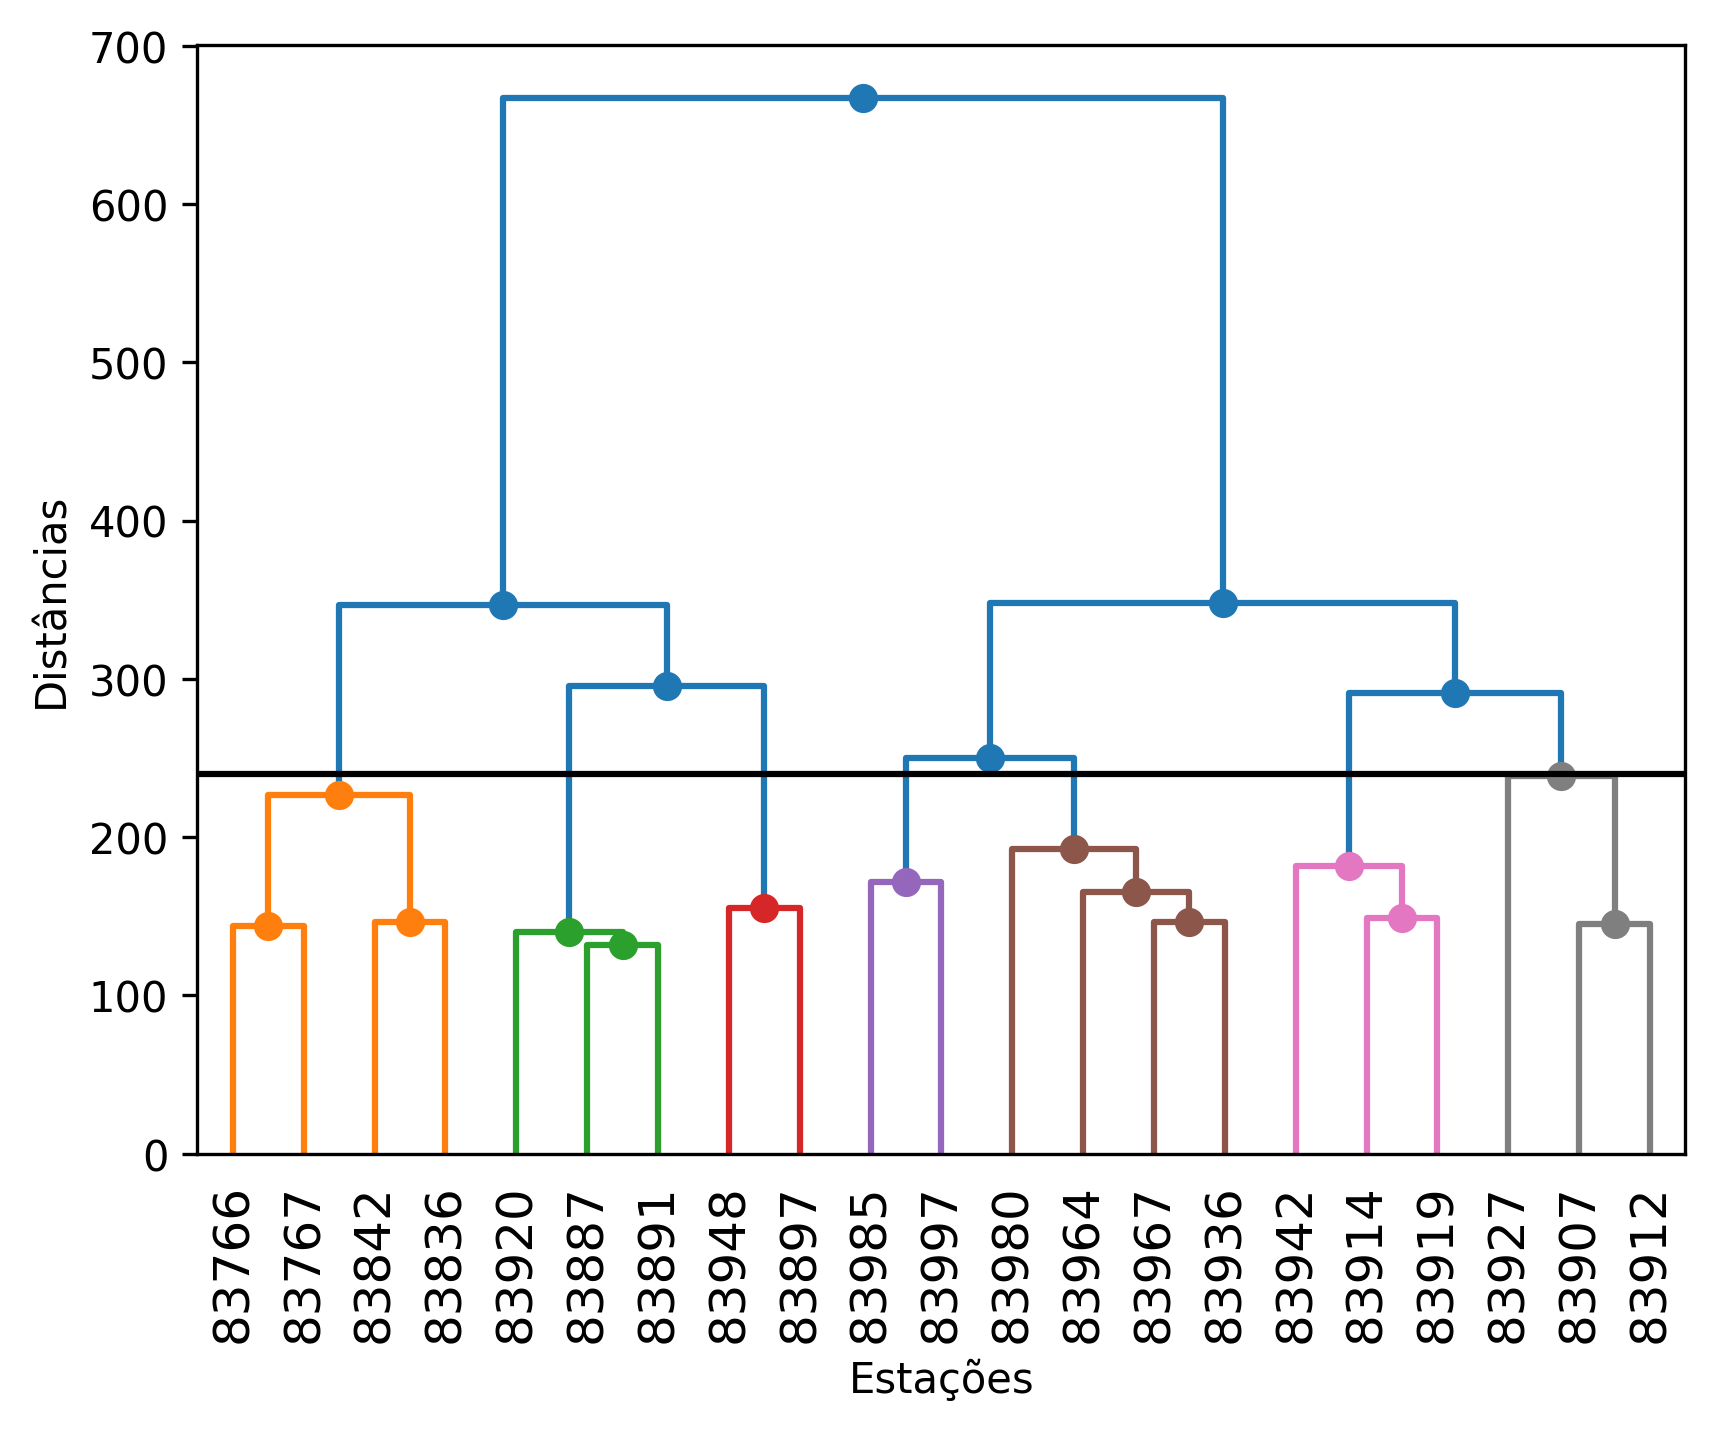

In [22]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster

labels = list(anom_data.index)
max_d = 240
Z = linkage(pdist(anom_data.values), 'ward')
clusters = fcluster(Z,max_d,criterion='distance')

fig, ax = plt.subplots(1,1, dpi=300, sharey=True)
D = fancy_dendrogram(
    ax,
    Z,
    truncate_mode='lastp',
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=max_d,
    labels=labels,
)

# x, y = 0.03, 0.95
# for i, letter in enumerate(['A)', 'B)']):
#     ax[i].annotate(letter, xy=(x, y), xycoords='axes fraction', color='black', fontsize=14,
#                 bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))
#     #x += 1.15  # Movendo para baixo para o próximo grupo

# last = Z[:,2]
# last = last[::-1]
# acceleration = np.diff(last, 2)
# ax[1].plot(list(range(len(last))), last)
# ax[1].axhline(y=max_d, c='k')
# ax[1].set_xlabel('Estágios')
plt.savefig('dendrogram.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [23]:
def calculate_wcss(data):
    wcss = []
    for n in range(1, 20):
        kmeans = KMeans(n_clusters=n)
        kmeans.fit(X=data)
        wcss.append(kmeans.inertia_ / 10**(-5))

    return wcss 

def optimal_number_of_clusters(wcss):
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2

In [24]:
code2group = dict(zip(
    D['ivl'], 
    [c.replace('C','G') for c in D['leaves_color_list']]
))
group2color = {'G1': 'orange', 'G2': 'green', 'G3': 'red', 'G4': 'purple', 'G5': 'brown', 'G6': 'pink', 'G7':'gray'}

def get_groups(group):
    return [k for k, v in codes2group.items() if v == group]


#groups_ward = anom_data.copy()
groups_ward = tmean_data.copy()

groups_ward['groups'] = None
for code, _df in groups_ward.iterrows():
    groups_ward.loc[code,'groups'] = code2group.get(code)

groups_ward = groups_ward.groupby('groups').mean().T
groups_ward.index = pd.to_datetime(groups_ward.index)
groups_ward = pd.DataFrame(groups_ward.values, index=groups_ward.index, columns=list(groups_ward.columns))

# groups_ward.insert(0, 'labels', [c.replace('C','G') for c in D['leaves_color_list']])
# groups_ward = groups_ward.groupby('labels').mean().T
# groups_ward.index = pd.to_datetime(groups_ward.index)

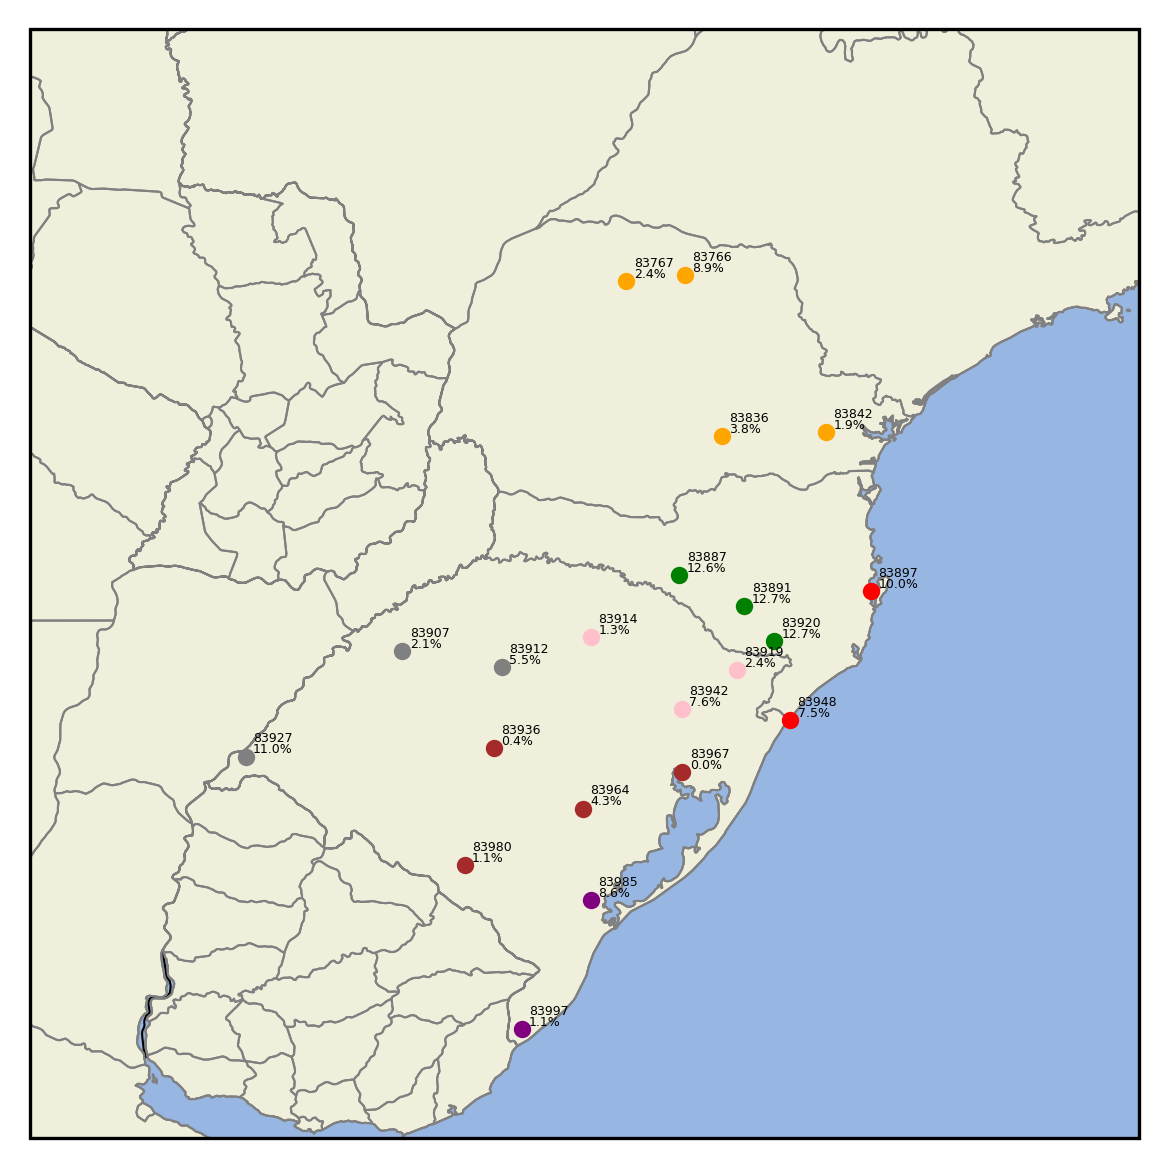

In [25]:
fig = plt.figure(dpi=300)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-60, -45, -35, -20], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, edgecolor='gray', linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, edgecolor='gray', linewidth=0.5)
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.5)

# x, y = 0.1, 0.8 #1.02
# for group, color in group_colors.items():
#     ax.annotate(group, xy=(x, y), xycoords='axes fraction', color='white', fontsize=6,
#                 bbox=dict(facecolor=color, edgecolor='black', boxstyle='round,pad=0.3'))#, alpha=0.7))
#     x += 0.06  # Movendo para baixo para o próximo grupo

marker = 'o'
for code, row in cidades.iterrows():
    
    color = group2color.get(code2group.get(code))
        
    ax.scatter(row['lons'], row['lats'], transform=ccrs.PlateCarree(),
          color=color, s=10, zorder=5, marker=marker)
    # ax.text(row['lons']+0.1, row['lats']+0., str(round(row['alt'],0)/1000) + 'km',
    #         transform=ccrs.PlateCarree(),
    #         fontsize=3, 
    #         color='black', zorder=100,
    #         verticalalignment='center')
    ax.text(row['lons']+0.1, row['lats']+0.1, str(row['percent_null']) + '%',
            transform=ccrs.PlateCarree(),
            fontsize=3, 
            color='black', zorder=100,
            verticalalignment='center')
    ax.text(row['lons']+0.1, row['lats']+0.25, code,
            transform=ccrs.PlateCarree(),
            fontsize=3,
            color='black', zorder=100,
            verticalalignment='center')

plt.savefig('stations_ward.png')
plt.show()

/tmp/ipykernel_82347/3874675822.py:2: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  values_ward = groups_ward.resample('m').mean()


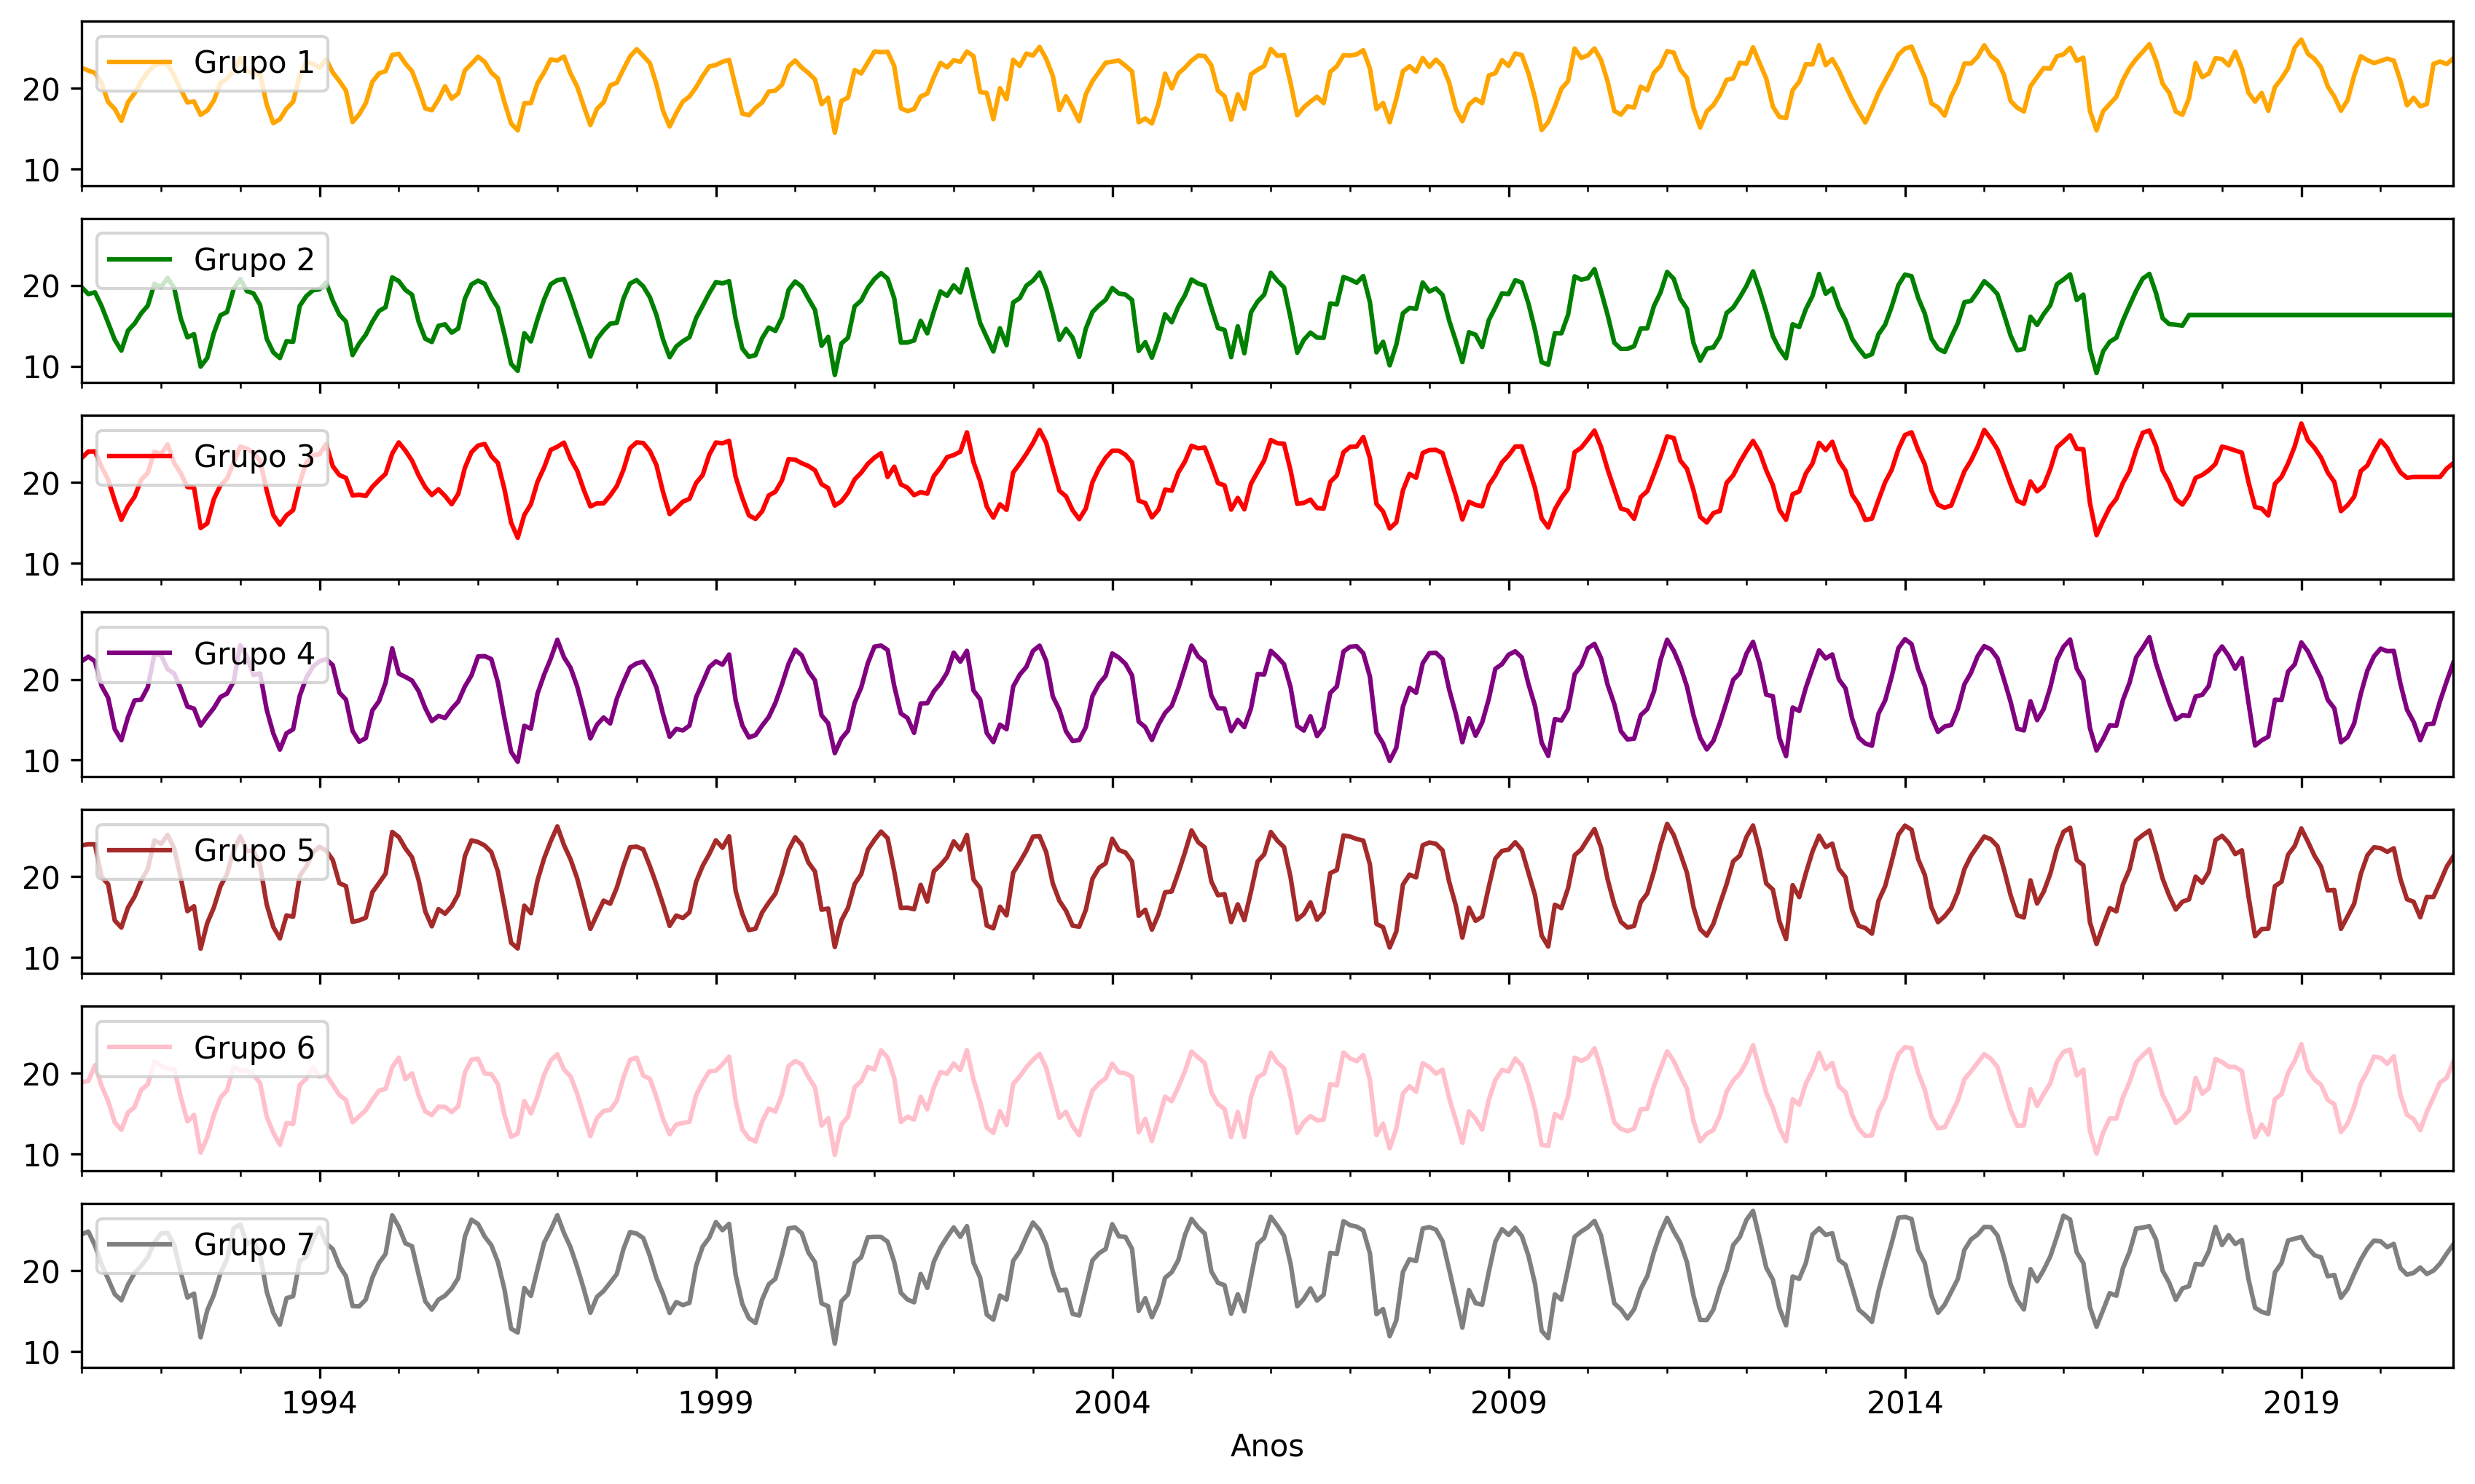

In [26]:
fig, ax = plt.subplots(7,1, dpi=300, sharey=True, sharex=True)
values_ward = groups_ward.resample('m').mean()
#values_kmeans.index = [datetime(1991,m,1).strftime('%b') for m in values_kmeans.index] 
values_ward['G1'].plot(ax=ax[0], alpha=1, subplots=False, figsize=(14,8), label='Grupo 1', color=group2color.get('G1'))
values_ward['G2'].plot(ax=ax[1], alpha=1, subplots=False, figsize=(14,8), label='Grupo 2', color=group2color.get('G2'))
values_ward['G3'].plot(ax=ax[2], alpha=1, subplots=False, figsize=(14,8), label='Grupo 3', color=group2color.get('G3'))
values_ward['G4'].plot(ax=ax[3], alpha=1, subplots=False, figsize=(14,8), label='Grupo 4', color=group2color.get('G4'))
values_ward['G5'].plot(ax=ax[4], alpha=1, subplots=False, figsize=(14,8), label='Grupo 5', color=group2color.get('G5'))
values_ward['G6'].plot(ax=ax[5], alpha=1, subplots=False, figsize=(14,8), label='Grupo 6', color=group2color.get('G6'))
values_ward['G7'].plot(ax=ax[6], alpha=1, subplots=False, figsize=(14,8), xlabel='Anos', label='Grupo 7', color=group2color.get('G7'))

# ax[0].axhline(lw=1, linestyle='dotted', color='black', zorder=-1)
# ax[1].axhline(lw=1, linestyle='dotted', color='black', zorder=-1)
# ax[2].axhline(lw=1, linestyle='dotted', color='black', zorder=-1)
# ax[3].axhline(lw=1, linestyle='dotted', color='black', zorder=-1)
# ax[4].axhline(lw=1, linestyle='dotted', color='black', zorder=-1)
# ax[5].axhline(lw=1, linestyle='dotted', color='black', zorder=-1)
# ax[6].axhline(lw=1, linestyle='dotted', color='black', zorder=-1)
vmin, vmax = -4, 4
# ax[0].set_ylim(vmin, vmax)
# ax[1].set_ylim(vmin, vmax)
# ax[2].set_ylim(vmin, vmax)
# ax[3].set_ylim(vmin, vmax)
# ax[4].set_ylim(vmin, vmax)
# ax[5].set_ylim(vmin, vmax)
# ax[6].set_ylim(vmin, vmax)

ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')
ax[2].legend(loc='upper left')
ax[3].legend(loc='upper left')
ax[4].legend(loc='upper left')
ax[5].legend(loc='upper left')
ax[6].legend(loc='upper left')
#plt.savefig('monthly_mean_groups_temperature_kmeans.pdf', format='pdf', bbox_inches='tight')

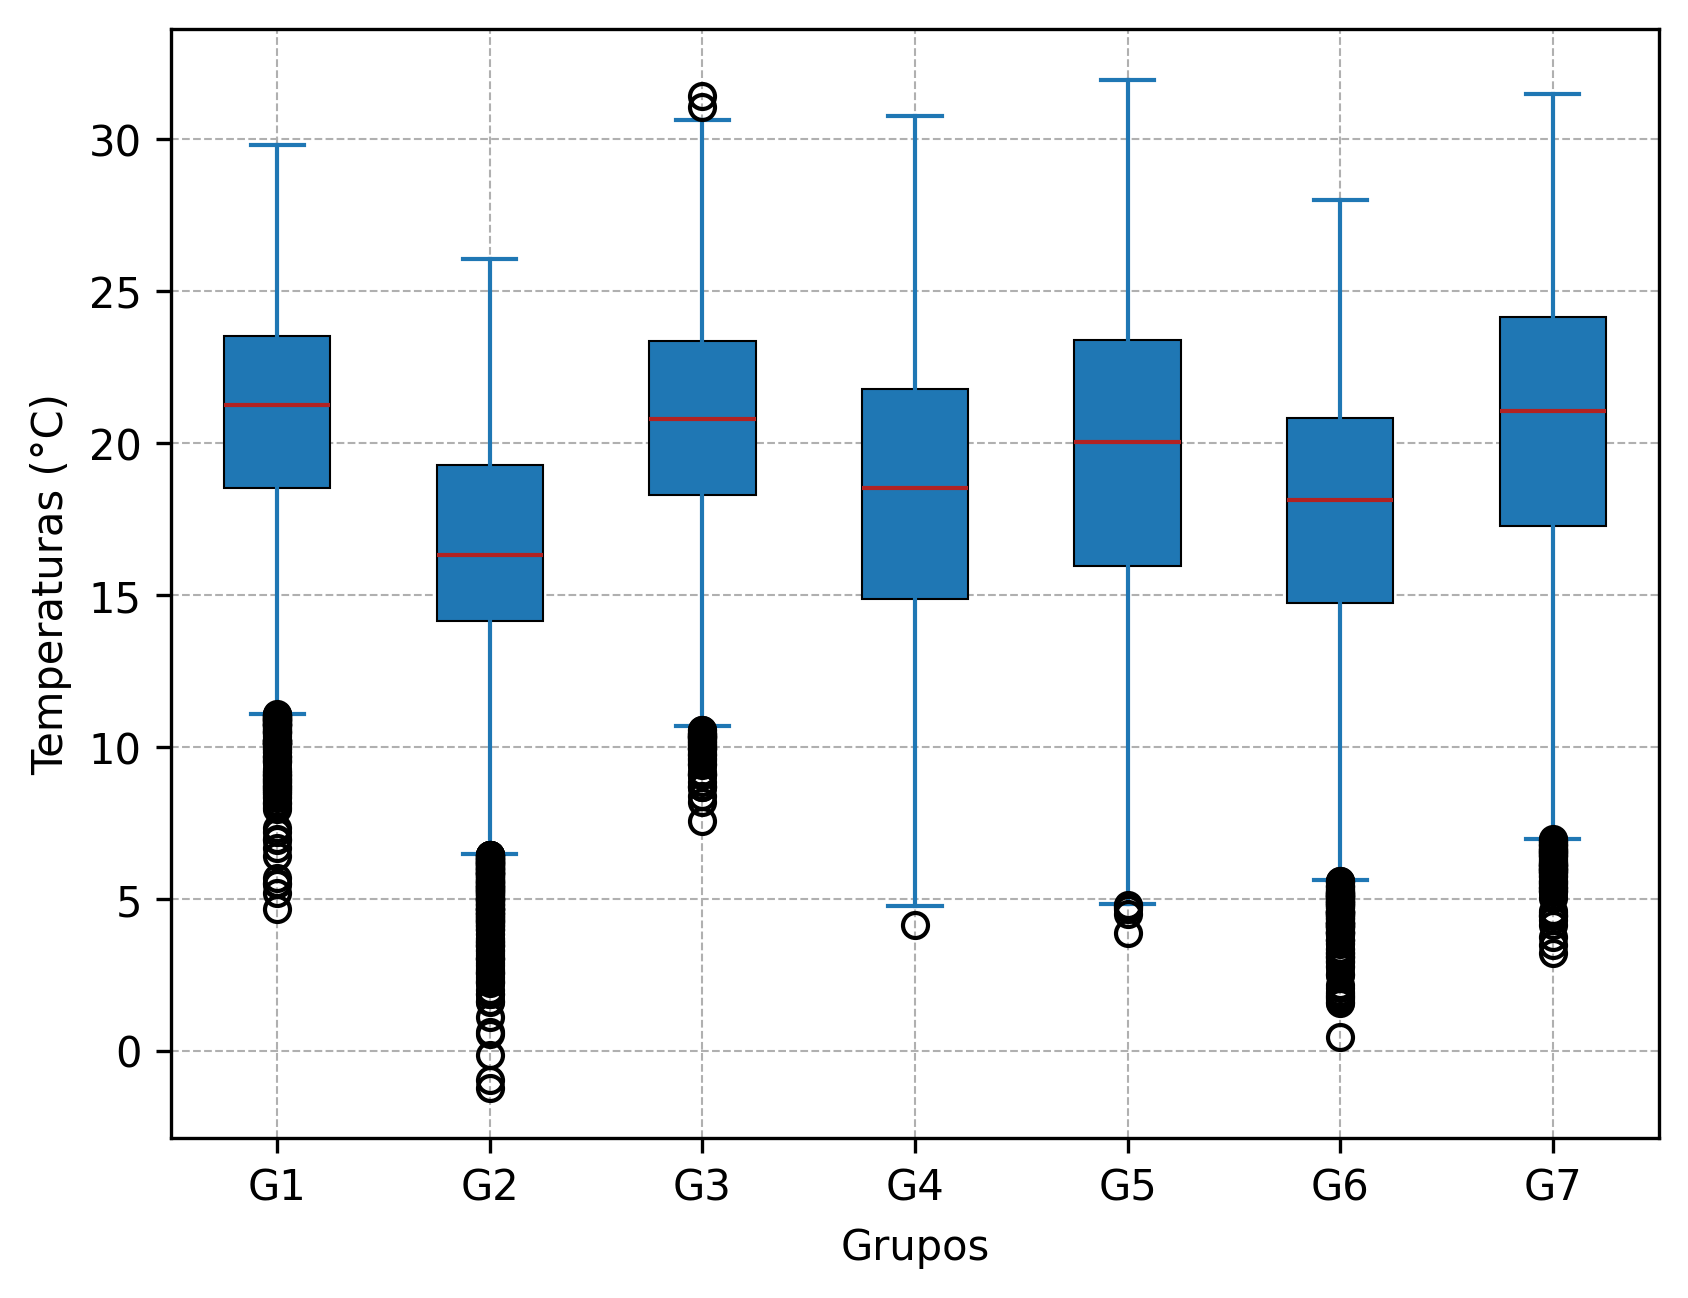

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, dpi=300, sharex=True)
values_ward = groups_ward #.resample('Y').mean()

# Plotando os boxplots com cores diferentes
boxprops = dict(linestyle='-', linewidth=.5, color='k')
medianprops = dict(linestyle='-', linewidth=1, color='firebrick')
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightpink', 'lightyellow']

values_ward[['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7']].plot.box(
        ax=ax, 
        subplots=False, 
        sharey=True, 
        sharex=True, 
        boxprops=boxprops, 
        medianprops=medianprops, 
        patch_artist=True
)

for patch, color in zip(ax.artists, colors):
        patch.set_facecolor(color)

#ax.set_ylim(-15, 15)
ax.set_xlabel('Grupos')
ax.set_ylabel('Temperaturas (°C)', fontsize=10)
#ax.set_title('Média de anomalia trimestral de temperatura')
ax.grid(True, linestyle='--', linewidth=0.5)

#plt.savefig('boxplot_temperature_ward.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
# # Aplicação do KMeans
# kmeans = KMeans(n_clusters=7, random_state=0, n_init="auto").fit(anom_data.values)
# labels = [f"G{int(l+1)}" for l in kmeans.labels_]
# code2group = dict(zip(anom_data.index, labels))

# groups_kmeans = anom_data.copy()
# groups_kmeans.insert(0, 'labels', labels)
# groups_kmeans = groups_kmeans.groupby('labels').mean().T
# groups_kmeans.index = pd.to_datetime(groups_kmeans.index)

In [ ]:
# fig = plt.figure(dpi=300)
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([-60, -47, -35, -22], crs=ccrs.PlateCarree())

# ax.add_feature(cfeature.LAND, edgecolor='gray', linewidth=0.5)
# ax.add_feature(cfeature.BORDERS, linewidth=0.5)
# ax.add_feature(cfeature.OCEAN, edgecolor='gray', linewidth=0.5)
# ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.5)
# x, y = 0.1, 0.9
# for group, color in group_colors.items():
#     ax.annotate(group, xy=(x, y), xycoords='axes fraction', color='black', fontsize=6,
#                 bbox=dict(facecolor=color, edgecolor=color, boxstyle='round,pad=0.3', alpha=0.7))
#     y -= 0.04  # Movendo para baixo para o próximo grupo


# scatters = []
# for code, row in cidades.iterrows():
#     label = code2group.get(code)
#     color = group2color.get(label)
    
#     scatter = ax.scatter(row['lons'], row['lats'], transform=ccrs.PlateCarree(),
#                          color=color, s=10, zorder=5, marker='o')
    
#     ax.text(row['lons']+0.1, row['lats']+0., str(round(row['alt'],3)) + 'm',
#             transform=ccrs.PlateCarree(),
#             fontsize=4, 
#             color='black', zorder=100,
#             verticalalignment='center')
#     ax.text(row['lons']+0.1, row['lats']+0.5, str(row['percent_null']) + '%',
#             transform=ccrs.PlateCarree(),
#             fontsize=4, 
#             color='black', zorder=100,
#             verticalalignment='center')
#     ax.text(row['lons']+0.1, row['lats']+0.25, code,
#             transform=ccrs.PlateCarree(),
#             fontsize=4,
#             color='black', zorder=100,
#             verticalalignment='center')

# # Salvamento e exibição da imagem
# plt.savefig('stations_kmeans.png')
# plt.show()

In [ ]:
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(1, 1, figsize=(14,8), sharex=True, sharey=True)
# values_kmeans = groups_kmeans #.resample('ME').mean()

# # Plotando os boxplots com cores diferentes
# boxprops = dict(linestyle='-', linewidth=.5, color='k')
# medianprops = dict(linestyle='-', linewidth=1, color='firebrick')

# values_kmeans[['G1', 'G2', 'G3', 'G4', 'G5']].plot.box(
#         ax=ax, 
#         subplots=False, 
#         sharey=True, 
#         sharex=True, 
#         boxprops=boxprops, 
#         medianprops=medianprops, 
#         patch_artist=True
# )
# for patch, color in zip(ax.artists, colors):
#     patch.set_facecolor(color)

# plt.savefig('boxplot_anom_temperature_kmeans.pdf', format='pdf', bbox_inches='tight')
# plt.show()

/tmp/ipykernel_82347/3462607019.py:2: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  values_ward = groups_ward.resample('m').mean()


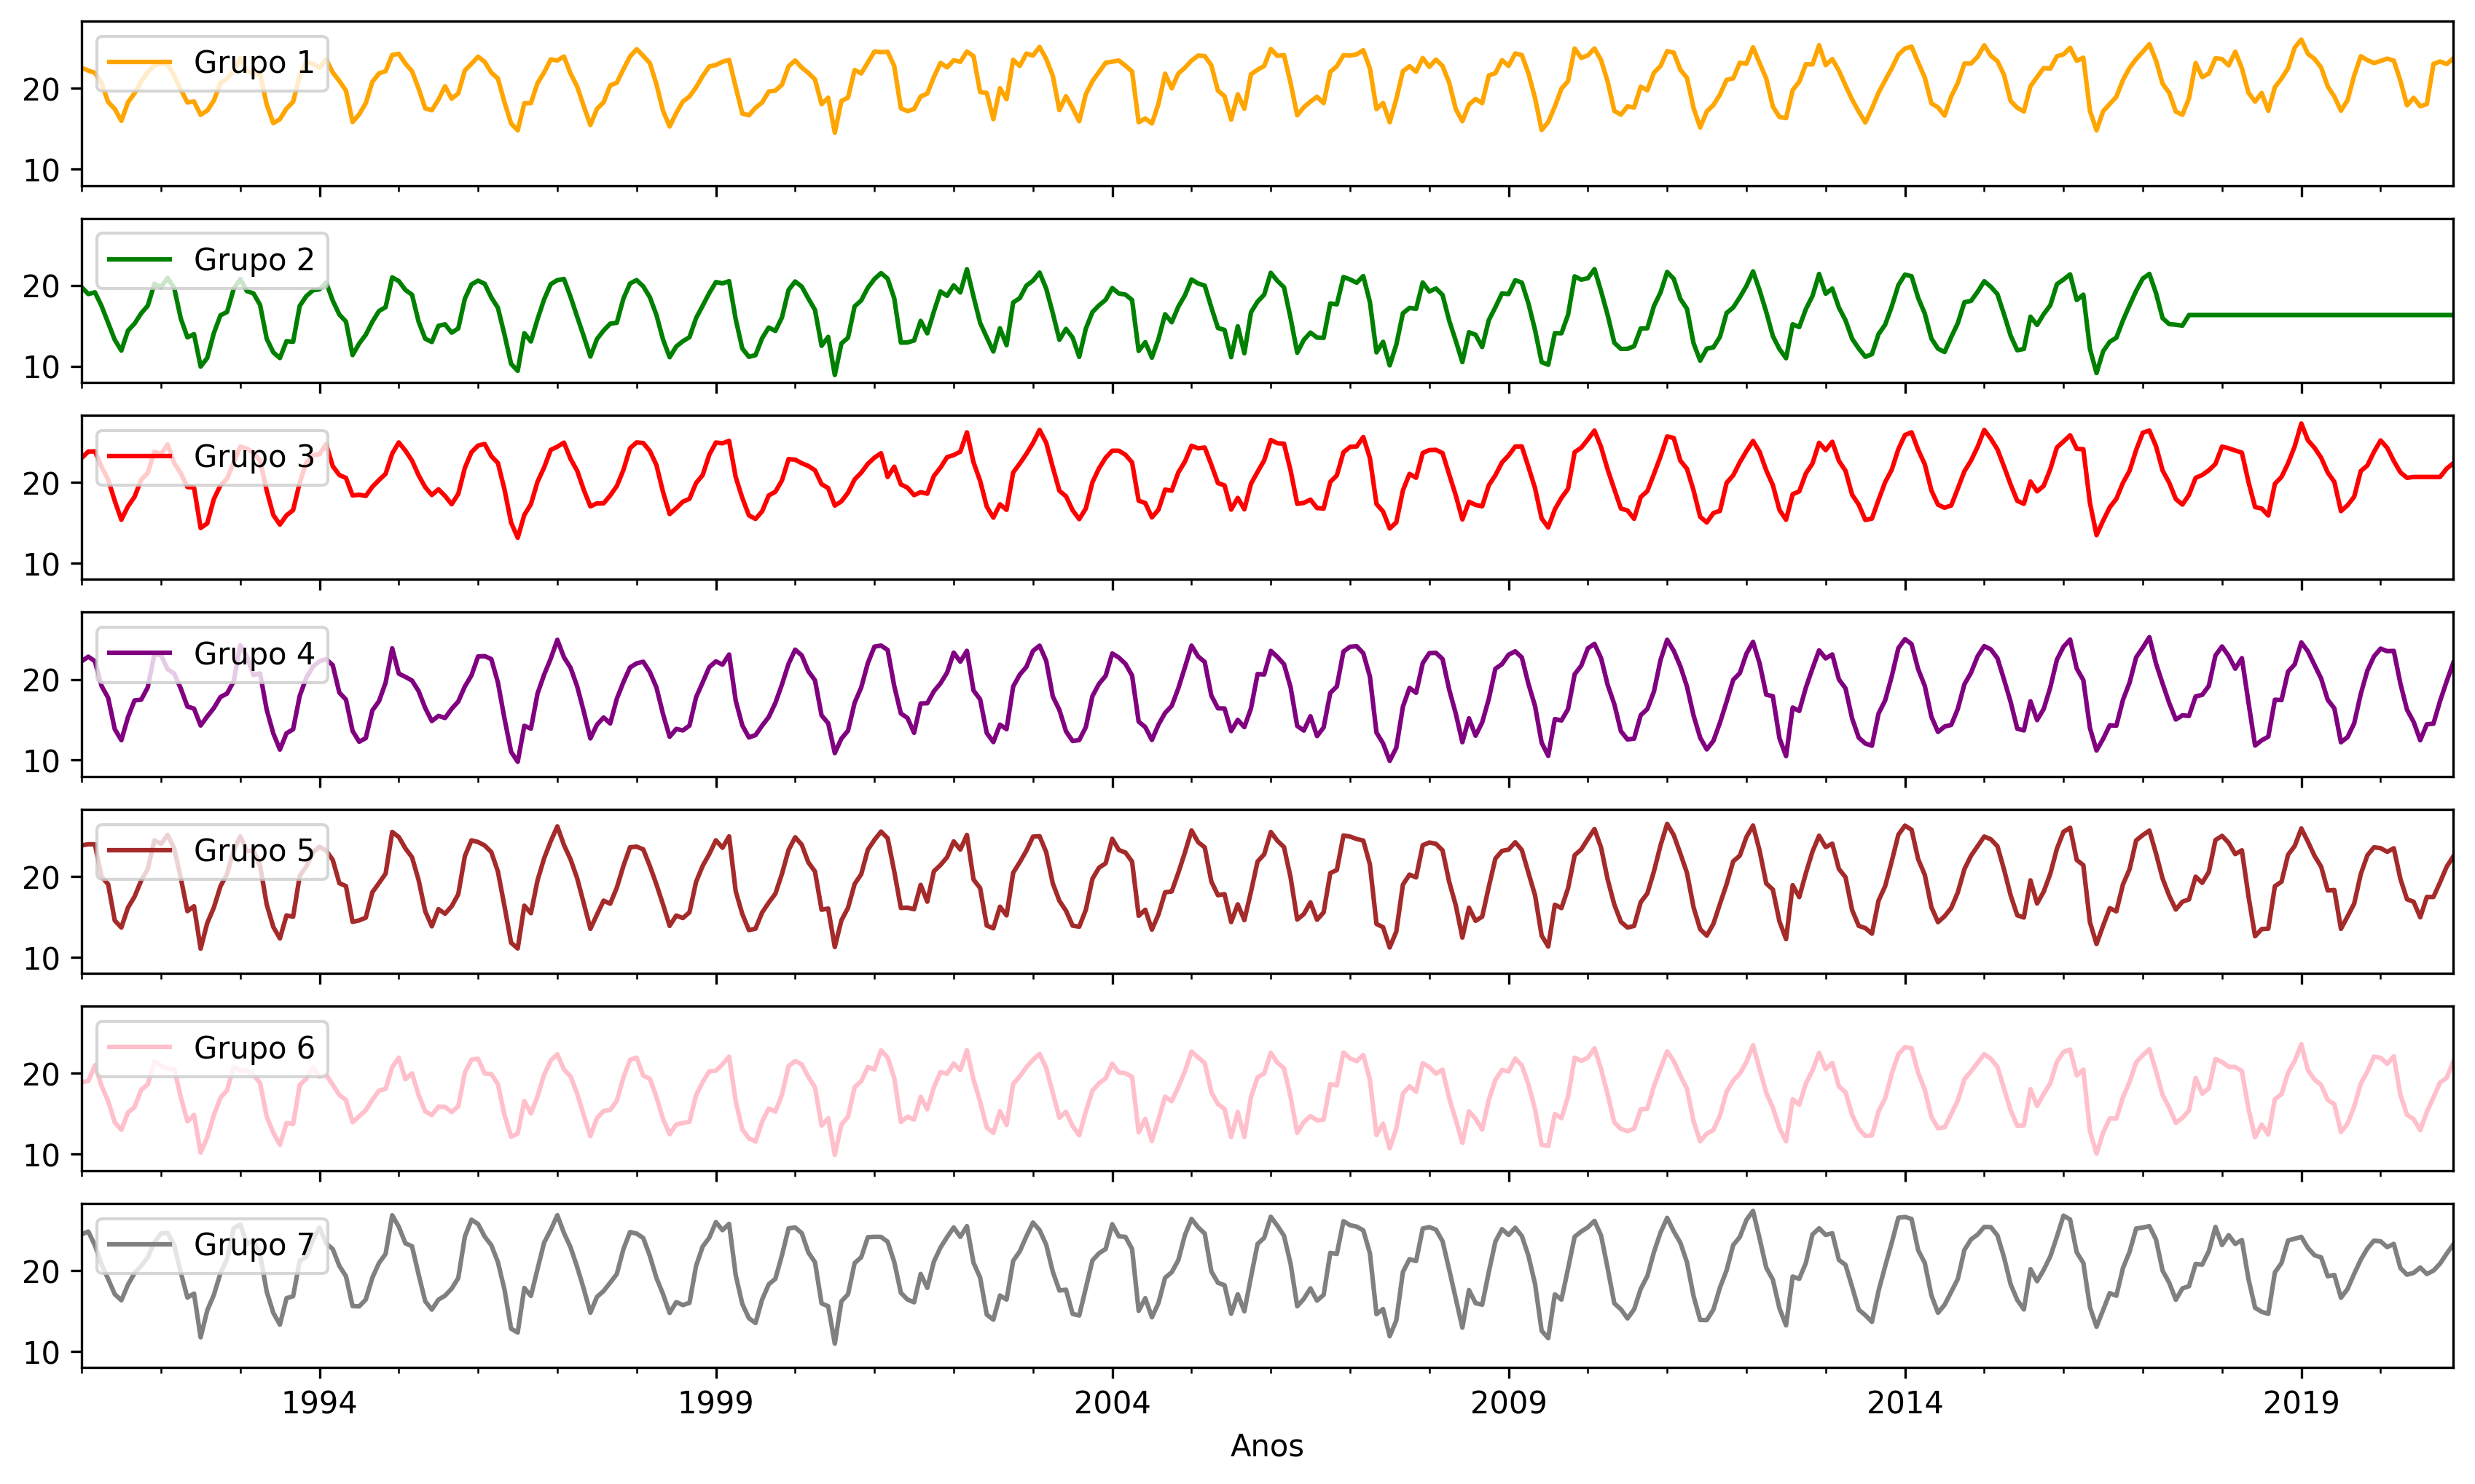

In [28]:
fig, ax = plt.subplots(7,1, dpi=300, sharey=True, sharex=True)
values_ward = groups_ward.resample('m').mean()
#values_kmeans.index = [datetime(1991,m,1).strftime('%b') for m in values_kmeans.index] 
values_ward['G1'].plot(ax=ax[0], alpha=1, subplots=False, figsize=(14,8), label='Grupo 1', color=group2color.get('G1'))
values_ward['G2'].plot(ax=ax[1], alpha=1, subplots=False, figsize=(14,8), label='Grupo 2', color=group2color.get('G2'))
values_ward['G3'].plot(ax=ax[2], alpha=1, subplots=False, figsize=(14,8), label='Grupo 3', color=group2color.get('G3'))
values_ward['G4'].plot(ax=ax[3], alpha=1, subplots=False, figsize=(14,8), label='Grupo 4', color=group2color.get('G4'))
values_ward['G5'].plot(ax=ax[4], alpha=1, subplots=False, figsize=(14,8), label='Grupo 5', color=group2color.get('G5'))
values_ward['G6'].plot(ax=ax[5], alpha=1, subplots=False, figsize=(14,8), label='Grupo 6', color=group2color.get('G6'))
values_ward['G7'].plot(ax=ax[6], alpha=1, subplots=False, figsize=(14,8), xlabel='Anos', label='Grupo 7', color=group2color.get('G7'))

# ax[0].axhline(lw=1, linestyle='dotted', color='black', zorder=-1)
# ax[1].axhline(lw=1, linestyle='dotted', color='black', zorder=-1)
# ax[2].axhline(lw=1, linestyle='dotted', color='black', zorder=-1)
# ax[3].axhline(lw=1, linestyle='dotted', color='black', zorder=-1)
# ax[4].axhline(lw=1, linestyle='dotted', color='black', zorder=-1)
# ax[5].axhline(lw=1, linestyle='dotted', color='black', zorder=-1)
# ax[6].axhline(lw=1, linestyle='dotted', color='black', zorder=-1)
# vmin, vmax = -4, 4
# ax[0].set_ylim(vmin, vmax)
# ax[1].set_ylim(vmin, vmax)
# ax[2].set_ylim(vmin, vmax)
# ax[3].set_ylim(vmin, vmax)
# ax[4].set_ylim(vmin, vmax)
# ax[5].set_ylim(vmin, vmax)
# ax[6].set_ylim(vmin, vmax)

ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')
ax[2].legend(loc='upper left')
ax[3].legend(loc='upper left')
ax[4].legend(loc='upper left')
ax[5].legend(loc='upper left')
ax[6].legend(loc='upper left')
#plt.savefig('monthly_mean_groups_temperature_kmeans.pdf', format='pdf', bbox_inches='tight')

/tmp/ipykernel_82347/4119948394.py:5: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  values_kmeans = groups_ward.resample('m').mean()


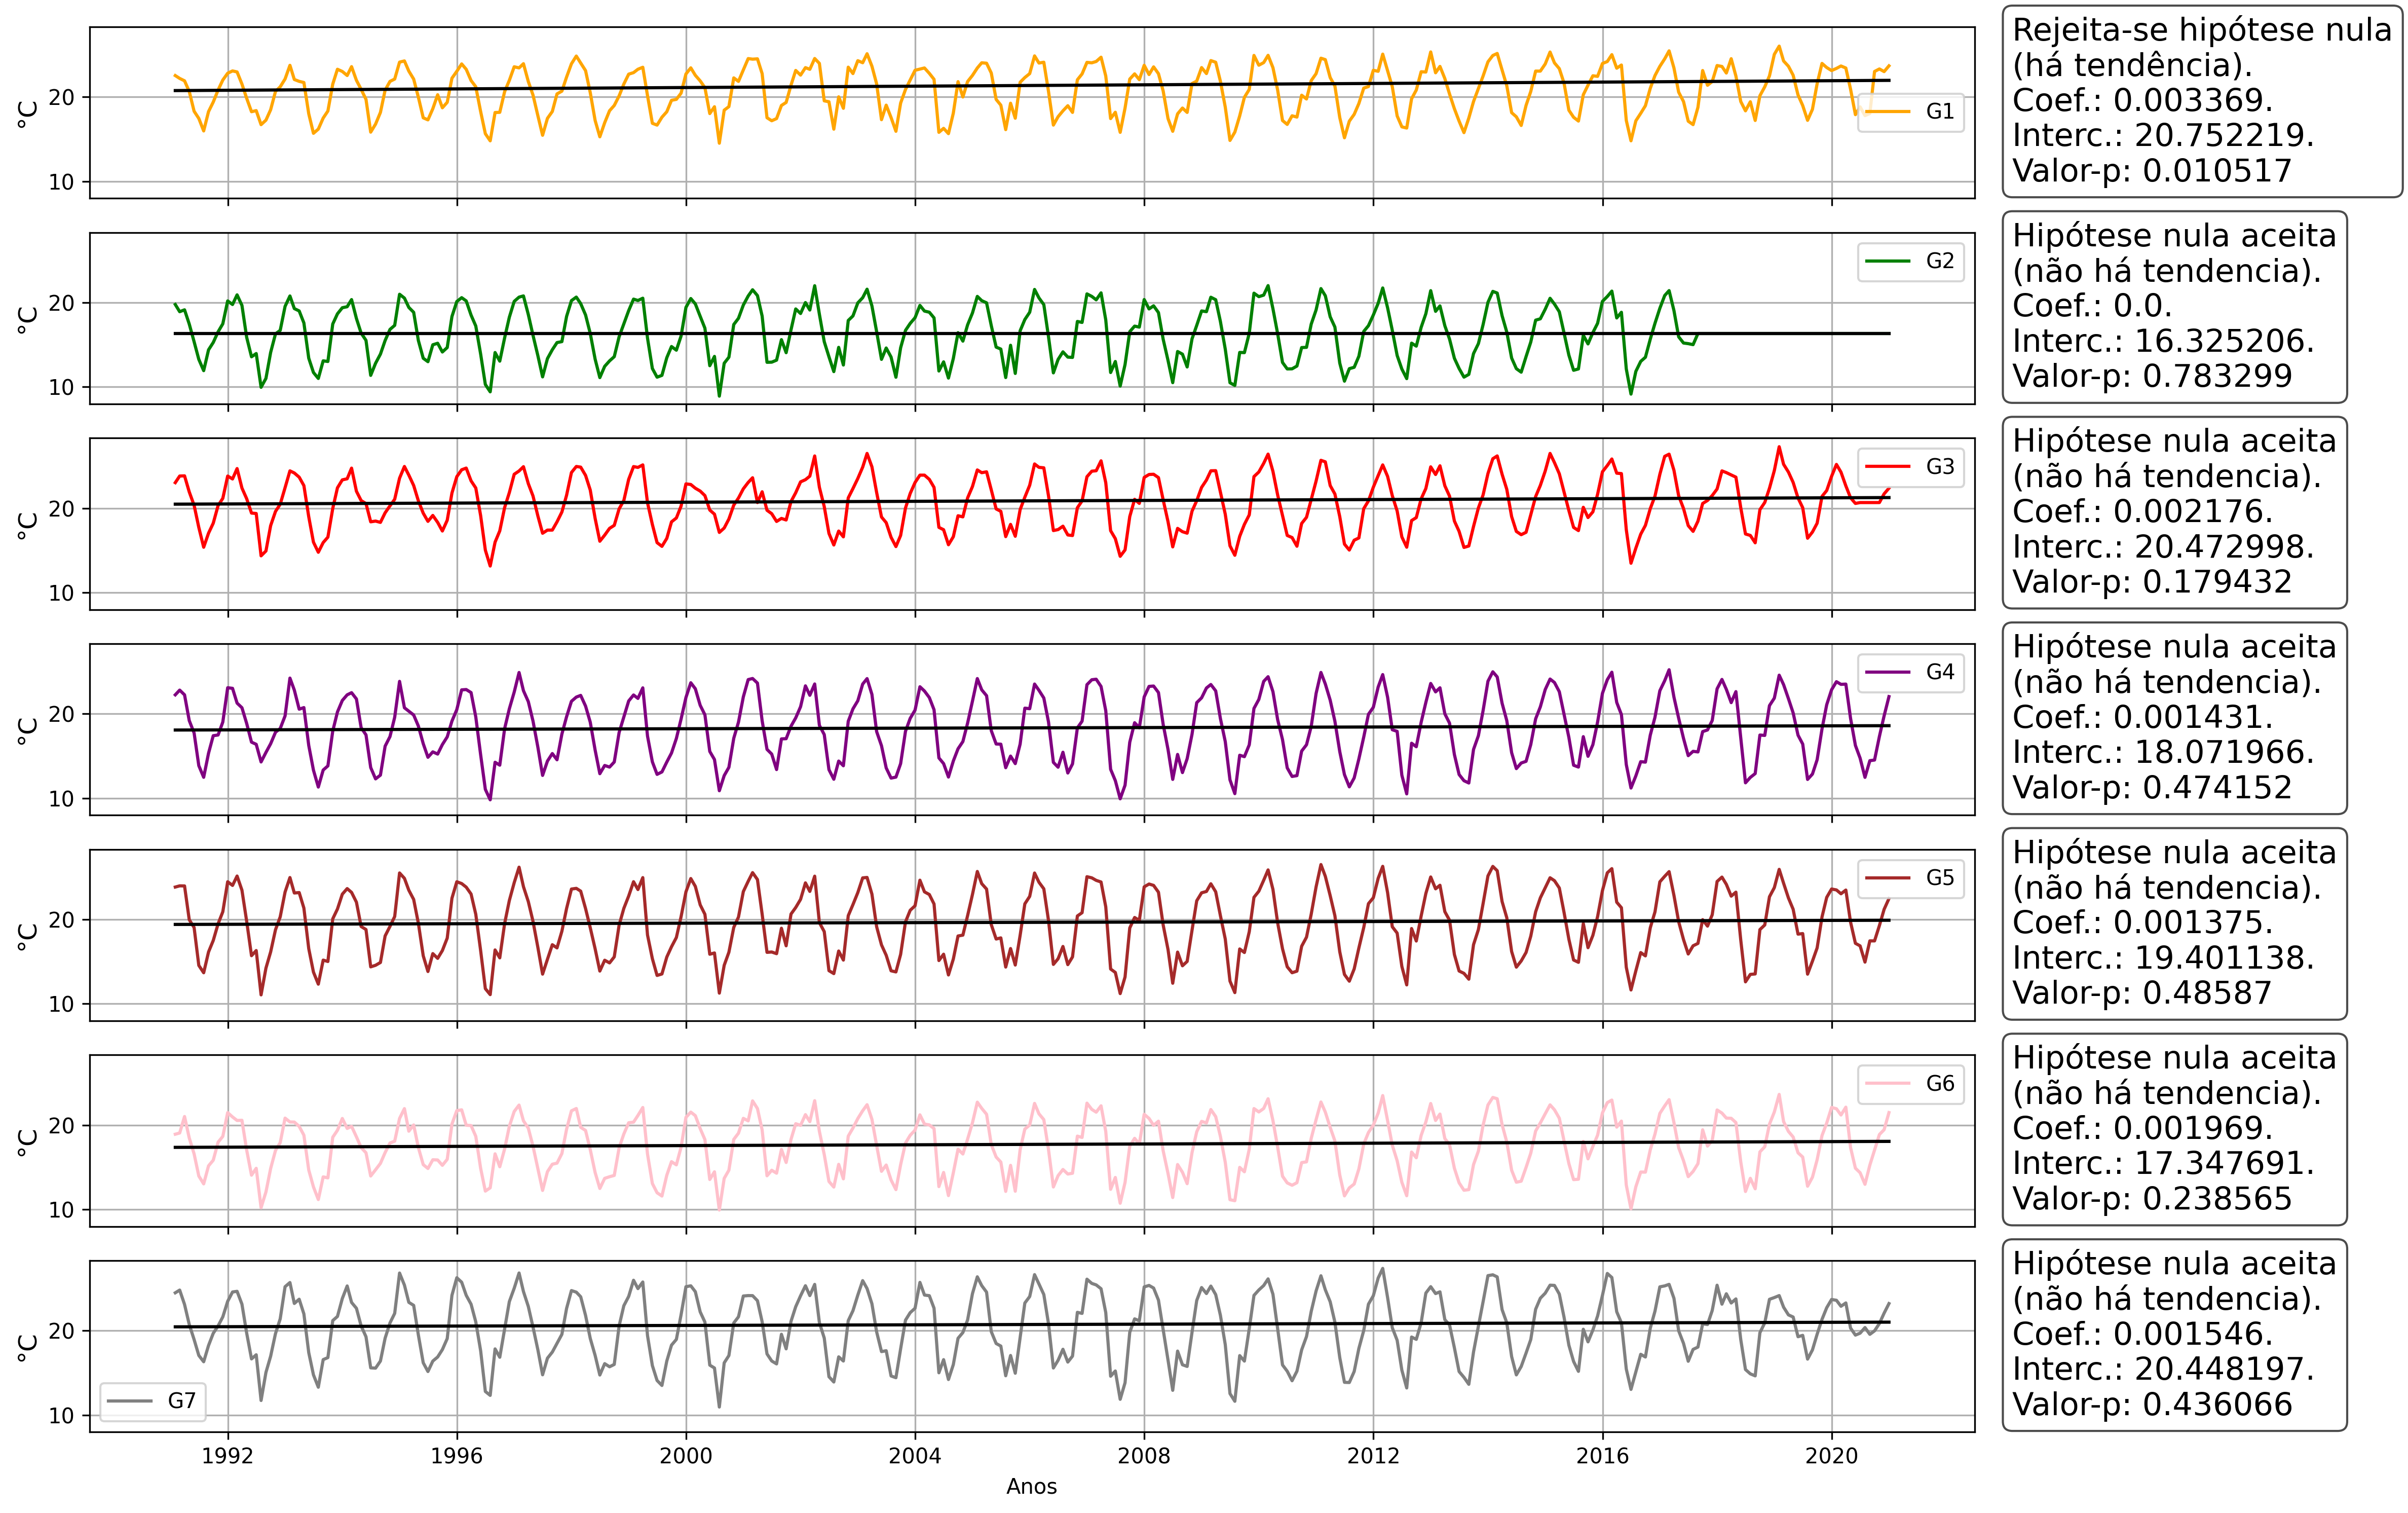

In [31]:
import pymannkendall as mk

fig, ax = plt.subplots(7,1, figsize=(16,12), dpi=300, sharey=True, sharex=True)

values_kmeans = groups_ward.resample('m').mean()

ax[0].plot(values_kmeans.loc[:, 'G1'].index, values_kmeans.loc[:, 'G1'], label='G1', color=group2color.get('G1'))
resultado = mk.original_test(values_kmeans.loc[:, 'G1'], alpha=0.05)
if resultado.trend == 'increasing':
    label = f'Rejeita-se hipótese nula\n(há tendência).\nCoef.: {round(float(resultado.slope),6)}.\nInterc.: {round(float(resultado.intercept),6)}.\nValor-p: {round(float(resultado.p),6)}'
else:
    label = f'Hipótese nula aceita\n(não há tendencia).\nCoef.: {round(float(resultado.slope),6)}.\nInterc.: {round(float(resultado.intercept),6)}.\nValor-p: {round(float(resultado.p),6)}'
trend_line = np.arange(len(values_kmeans.loc[:, 'G1'])) * resultado.slope + resultado.intercept
ax[0].plot(values_kmeans.loc[:, 'G1'].index, trend_line, color='black')

x, y = 1.02, 0.1
ax[0].annotate(
    label, 
    xy=(x, y), xycoords='axes fraction', color='black', fontsize=15,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))

ax[0].set_ylabel('°C', fontsize=12)
#ax[0].set_ylim(-4,4)
ax[0].grid()
ax[0].legend(loc='right')

ax[1].plot(values_kmeans.iloc[:, :].index, values_kmeans.loc[:, 'G2'], label='G2', color=group2color.get('G2'))
resultado = mk.original_test(values_kmeans.loc[:, 'G2'], alpha=0.05)
if resultado.trend == 'increasing':
    label = f'Rejeita-se hipótese nula\n(há tendência).\nCoef.: {round(float(resultado.slope),6)}.\nInterc.: {round(float(resultado.intercept),6)}.\nValor-p: {round(float(resultado.p),6)}'
else:
    label = f'Hipótese nula aceita\n(não há tendencia).\nCoef.: {round(float(resultado.slope),6)}.\nInterc.: {round(float(resultado.intercept),6)}.\nValor-p: {round(float(resultado.p),6)}'
trend_line = np.arange(len(values_kmeans.loc[:, 'G2'])) * resultado.slope + resultado.intercept
ax[1].plot(values_kmeans.loc[:, 'G2'].index, trend_line, color='black')

x, y = 1.02, 0.1
ax[1].annotate(
    label, 
    xy=(x, y), xycoords='axes fraction', color='black', fontsize=15,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))

ax[1].set_ylabel('°C', fontsize=12)
#ax[1].set_ylim(-4,4)
ax[1].grid()
ax[1].legend()

ax[2].plot(values_kmeans.iloc[:, :].index, values_kmeans.loc[:, 'G3'], label='G3', color=group2color.get('G3'))
resultado = mk.original_test(values_kmeans.loc[:, 'G3'], alpha=0.05)
if resultado.trend == 'increasing':
    label = f'Rejeita-se hipótese nula\n(há tendência).\nCoef.: {round(float(resultado.slope),6)}.\nInterc.: {round(float(resultado.intercept),6)}.\nValor-p: {round(float(resultado.p),6)}'
else:
    label = f'Hipótese nula aceita\n(não há tendencia).\nCoef.: {round(float(resultado.slope),6)}.\nInterc.: {round(float(resultado.intercept),6)}.\nValor-p: {round(float(resultado.p),6)}'
trend_line = np.arange(len(values_kmeans.loc[:, 'G3'])) * resultado.slope + resultado.intercept
ax[2].plot(values_kmeans.loc[:, 'G3'].index, trend_line, color='black')

x, y = 1.02, 0.1
ax[2].annotate(
    label, 
    xy=(x, y), xycoords='axes fraction', color='black', fontsize=15,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))

ax[2].set_ylabel('°C', fontsize=12)
#ax[2].set_ylim(-4,4)
ax[2].grid()
ax[2].legend()

ax[3].plot(values_kmeans.iloc[:, :].index, values_kmeans.loc[:, 'G4'], label='G4', color=group2color.get('G4'))
resultado = mk.original_test(values_kmeans.loc[:, 'G4'], alpha=0.05)
if resultado.trend == 'increasing':
    label = f'Rejeita-se hipótese nula\n(há tendência).\nCoef.: {round(float(resultado.slope),6)}.\nInterc.: {round(float(resultado.intercept),6)}.\nValor-p: {round(float(resultado.p),6)}'
else:
    label = f'Hipótese nula aceita\n(não há tendencia).\nCoef.: {round(float(resultado.slope),6)}.\nInterc.: {round(float(resultado.intercept),6)}.\nValor-p: {round(float(resultado.p),6)}'
trend_line = np.arange(len(values_kmeans.loc[:, 'G4'])) * resultado.slope + resultado.intercept
ax[3].plot(values_kmeans.loc[:, 'G4'].index, trend_line, color='black')

x, y = 1.02, 0.1
ax[3].annotate(
    label, 
    xy=(x, y), xycoords='axes fraction', color='black', fontsize=15,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))

ax[3].set_ylabel('°C', fontsize=12)
#ax[3].set_ylim(-4,4)
ax[3].grid()
ax[3].legend()

ax[4].plot(values_kmeans.iloc[:, :].index, values_kmeans.loc[:, 'G5'], label='G5', color=group2color.get('G5'))
resultado = mk.original_test(values_kmeans.loc[:, 'G5'], alpha=0.05)
if resultado.trend == 'increasing':
    label = f'Rejeita-se hipótese nula\n(há tendência).\nCoef.: {round(float(resultado.slope),6)}.\nInterc.: {round(float(resultado.intercept),6)}.\nValor-p: {round(float(resultado.p),6)}'
else:
    label = f'Hipótese nula aceita\n(não há tendencia).\nCoef.: {round(float(resultado.slope),6)}.\nInterc.: {round(float(resultado.intercept),6)}.\nValor-p: {round(float(resultado.p),6)}'
trend_line = np.arange(len(values_kmeans.loc[:, 'G5'])) * resultado.slope + resultado.intercept
ax[4].plot(values_kmeans.loc[:, 'G5'].index, trend_line, color='black')

x, y = 1.02, 0.1
ax[4].annotate(
    label, 
    xy=(x, y), xycoords='axes fraction', color='black', fontsize=15,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))

ax[4].set_ylabel('°C', fontsize=12)
#ax[4].set_ylim(-4,4)
ax[4].grid()
ax[4].legend()


ax[5].plot(values_kmeans.iloc[:, :].index, values_kmeans.loc[:, 'G6'], label='G6', color=group2color.get('G6'))
resultado = mk.original_test(values_kmeans.loc[:, 'G6'], alpha=0.05)
if resultado.trend == 'increasing':
    label = f'Rejeita-se hipótese nula\n(há tendência).\nCoef.: {round(float(resultado.slope),6)}.\nInterc.: {round(float(resultado.intercept),6)}.\nValor-p: {round(float(resultado.p),6)}'
else:
    label = f'Hipótese nula aceita\n(não há tendencia).\nCoef.: {round(float(resultado.slope),6)}.\nInterc.: {round(float(resultado.intercept),6)}.\nValor-p: {round(float(resultado.p),6)}'
trend_line = np.arange(len(values_kmeans.loc[:, 'G6'])) * resultado.slope + resultado.intercept
ax[5].plot(values_kmeans.loc[:, 'G6'].index, trend_line, color='black')

x, y = 1.02, 0.1
ax[5].annotate(
    label, 
    xy=(x, y), xycoords='axes fraction', color='black', fontsize=15,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))

ax[5].set_ylabel('°C', fontsize=12)
#ax[5].set_ylim(-4,4)
ax[5].grid()
ax[5].legend()


ax[6].plot(values_kmeans.iloc[:, :].index, values_kmeans.loc[:, 'G7'], label='G7', color=group2color.get('G7'))
resultado = mk.original_test(values_kmeans.loc[:, 'G7'], alpha=0.05)

if resultado.trend == 'increasing':
    label = f'Rejeita-se hipótese nula\n(há tendência).\nCoef.: {round(float(resultado.slope),6)}.\nInterc.: {round(float(resultado.intercept),6)}.\nValor-p: {round(float(resultado.p),6)}'
else:
    label = f'Hipótese nula aceita\n(não há tendencia).\nCoef.: {round(float(resultado.slope),6)}.\nInterc.: {round(float(resultado.intercept),6)}.\nValor-p: {round(float(resultado.p),6)}'
trend_line = np.arange(len(values_kmeans.loc[:, 'G7'])) * resultado.slope + resultado.intercept
ax[6].plot(values_kmeans.loc[:, 'G7'].index, trend_line, color='black')

x, y = 1.02, 0.1
ax[6].annotate(
    label, 
    xy=(x, y), xycoords='axes fraction', color='black', fontsize=15,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))

ax[6].set_ylabel('°C', fontsize=12)
ax[6].set_xlabel('Anos')
#ax[6].set_ylim(-4,4)
ax[6].grid()
ax[6].legend()

#plt.savefig('tendencia_anomalias_grupos.pdf', format='pdf', bbox_inches='tight')


In [ ]:
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(1, 1, figsize=(14, 12), sharex=True)


# # Plotando os boxplots com cores diferentes
# boxprops = dict(linestyle='-', linewidth=2, color='k')
# medianprops = dict(linestyle='-', linewidth=2.5, color='firebrick')
# colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightpink', 'lightyellow']

# groups_kmeans[['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7']].plot.box(
#         ax=ax, 
#         subplots=False, 
#         sharey=True, 
#         sharex=True, 
#         boxprops=boxprops, 
#         medianprops=medianprops, 
#         patch_artist=True
# )

# for patch, color in zip(ax.artists, colors):
#         patch.set_facecolor(color)

# ax.set_ylim(-15, 15)
# ax.set_xlabel('Grupos')
# ax.set_ylabel('Anomalias (°C)', fontsize=10)
# #ax.set_title('Média de anomalia trimestral de temperatura')
# ax.grid(True, linestyle='--', linewidth=0.5)

# #plt.savefig('groups_temperature_seasonal_kmeans.png')
# plt.show()

In [ ]:
anom_mean = extract(codes, df_done, variable='anom_mean', fillna=True)
tmean = extract(codes, df_done, variable='tmean', fillna=True)
mean = extract(codes, df_done, variable='mean', fillna=True)

teste = tmean.loc['83936'] - mean.loc['83936'] == anom_mean.loc['83936'].values

In [ ]:
tmean_groups = pd.DataFrame({'G1':tmean.T[get_groups('G1')].mean(axis=1), 
                             'G2':tmean.T[get_groups('G2')].mean(axis=1), 
                             'G3':tmean.T[get_groups('G3')].mean(axis=1), 
                             'G4':tmean.T[get_groups('G4')].mean(axis=1),
                             'G5':tmean.T[get_groups('G5')].mean(axis=1),
                             'G6':tmean.T[get_groups('G6')].mean(axis=1),
                             'G7':tmean.T[get_groups('G7')].mean(axis=1)})

mean_groups = pd.DataFrame({'G1':mean.T[get_groups('G1')].mean(axis=1), 
                             'G2':mean.T[get_groups('G2')].mean(axis=1), 
                             'G3':mean.T[get_groups('G3')].mean(axis=1), 
                             'G4':mean.T[get_groups('G4')].mean(axis=1),
                             'G5':mean.T[get_groups('G5')].mean(axis=1),
                             'G6':mean.T[get_groups('G6')].mean(axis=1),
                             'G7':mean.T[get_groups('G7')].mean(axis=1)})

anom_mean_groups = pd.DataFrame({'G1':anom_mean.T[get_groups('G1')].mean(axis=1), 
                             'G2':anom_mean.T[get_groups('G2')].mean(axis=1), 
                             'G3':anom_mean.T[get_groups('G3')].mean(axis=1), 
                             'G4':anom_mean.T[get_groups('G4')].mean(axis=1),
                             'G5':anom_mean.T[get_groups('G5')].mean(axis=1),
                             'G6':anom_mean.T[get_groups('G6')].mean(axis=1),
                             'G7':anom_mean.T[get_groups('G7')].mean(axis=1)})

In [ ]:
tmean_groups.to_csv('data/pos/filled_tmean_groups_kmeans.csv')

In [ ]:
mean_groups.to_csv('data/pos/filled_tmean_clim_groups_kmeans.csv')

In [ ]:
anom_mean_groups.to_csv('data/pos/filled_tmean_anomaly_groups_kmeans.csv')

In [ ]:
# calculando a soma dos quadrados para as 19 quantidade de clusters
sum_of_squares = calculate_wcss(anom_data.values)
# calculando a quantidade ótima de clusters
n = optimal_number_of_clusters(sum_of_squares)
# plt.plot(list(range(1,20,1)), sum_of_squares)
# plt.xlim(0,21)
# plt.xticks(list(range(0,21,2)));